# CNN resolution degrader

## Introduction
The scope of the work is to create a convolutional neural network that resizes images. The network is trained on real high and low images taken from different cameras. The results of such network are later compared with well known resizing algorithms. This is a preliminary step in advance of creating a system for data augmentation for super-resolution imaging. 

In [1]:
import inspect

from data_loader import *
from model import *
from analysis import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Data

### Images dataset
The provided data consists of two sets of aerial photographs – _NIR_ and _RED_. The directory with data is structured as follows:
```
dataset-v11
├── test
│   ├── NIR
│   │   ├── imageset0001
│   │   │   ├── HR000.png
│   │   │   ├── LR000.png
│   │   │   ├── QM000.png
│   │   │   ⋮
│   │   ⋮
│   │   
│   └── RED
│       ⋮
│
└── train
    ├── NIR
    │   ⋮
    │
    └── RED
        ⋮
```
Photos are 14-bit, grayscale images. In the dataset structure _imageset_ denotes a scene, which contains photos of the same landmark. Photos with the same index within scene were taken simultaneously. It is possible to use whole scene or just one sample per scene. Photos marked as _HR_ are high resolution – 378 by 378 pixels, whereas _LR_ are low resolution – 126 by 126 pixels; 3 times smaller. There are additional _QM_ masks, that mark areas covered by clouds. Using masks may be considered to alleviate the noise introduced by clouds. The aim is to make a network transforming _HR_ images into _LR_ images, thus they will be called _x_ and _y_ respectively. One should notice that _HR_ and _LR_ come from different cameras making photos and **are not the same image being rescaled**. This results in images being sometimes slightly shifted.

### Data loading and storing
The number of photos in dataset is quite big. Also, there is a need for some code to recurse directories, choose _NIR_ or _RED_ and specify number of images per scene. Because of this, loading images takes some time. Data loading and processing is located in the `data_loader.py` file. By default, it loads images into _numpy_ arrays and saves them as `.npy` files, each of which contains one imageset prepared for training a neural network. Each image is loaded taking 14-bits depth into consideration and stored as a float inside the `.npy` (`Pickle` is required to load data).

The '.npy' files are structured like:
```
[ [train_hr, train_lr, train_lr_masks],
  [test_hr, test_lr, test_lr_masks] ]
```
These files are created for both _NIR_ and _RED_, with one image per scene variants. The `data_loader.py` also provides some functions for transforming _x_ and _y_ parts of datasets as well as only _y_. This will come in handy later, during comparisons and analysis.

## Neural network
The default network model and training code are placed into `model.py`.

### Model
The neural network is very simple CNN that shrinks images by using convolution with proper stride size. The default model looks like this:

In [2]:
print(inspect.getsource(make_model))

def make_model():
    model = models.Sequential()

    model.add(layers.InputLayer(input_shape=(378, 378, 1)))
    model.add(layers.Conv2D(64, kernel_size=3,
                            padding='same', activation='relu'))
    model.add(layers.Conv2D(64, kernel_size=5, strides=3,
                            padding='same', activation='relu'))
    model.add(layers.Conv2D(1, kernel_size=3,
                            padding='same', activation='sigmoid'))
    return model



In [3]:
make_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 378, 378, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 64)      102464    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 1)       577       
Total params: 103,681
Trainable params: 103,681
Non-trainable params: 0
_________________________________________________________________


This rudimentary model has enough capacity to learn common resizing/resampling algorithms such as _bilinear_ and _bicubic_. Some more complex designs were tested (autoencoders), but for shrinking photos the bare-bones network is enough.

### Training
The network is trained as follows:

In [4]:
print(inspect.getsource(train))

def train(x_train, y_train):
    model = make_model()
    callbacks = make_callbacks(earlystopping=False)

    model.compile(loss=losses.MeanSquaredError(),
                  optimizer=optimizers.Adam(),
                  metrics=['mae'])

    model.summary()

    model.fit(x_train, y_train,
              validation_split=0.2,
              epochs=1,
              callbacks=callbacks)
    return model



### Notes on results
After training model, one can notice that it produces a bit more blurry objects than might have been expected. This is due to the bias in the exposure of _x_ and _y_ data, which may seem rather random, but the average exposure between _HR_ and _LR_ is slightly shifted. This makes the training process slow and results in blurry output of the network.

We can observe the exposure bias using box plots.

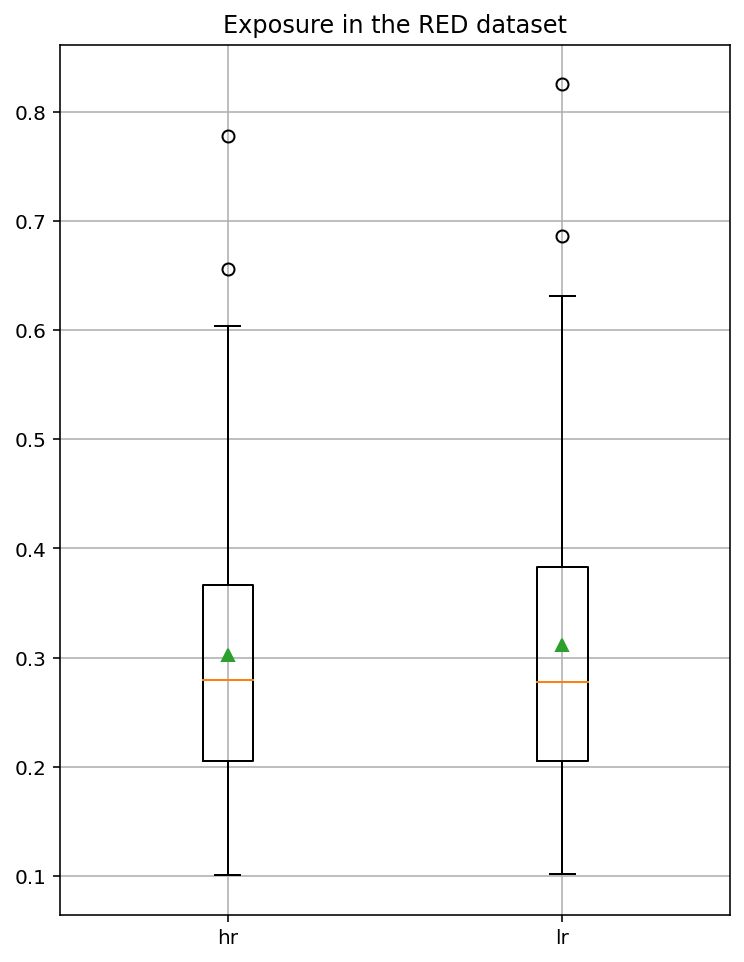

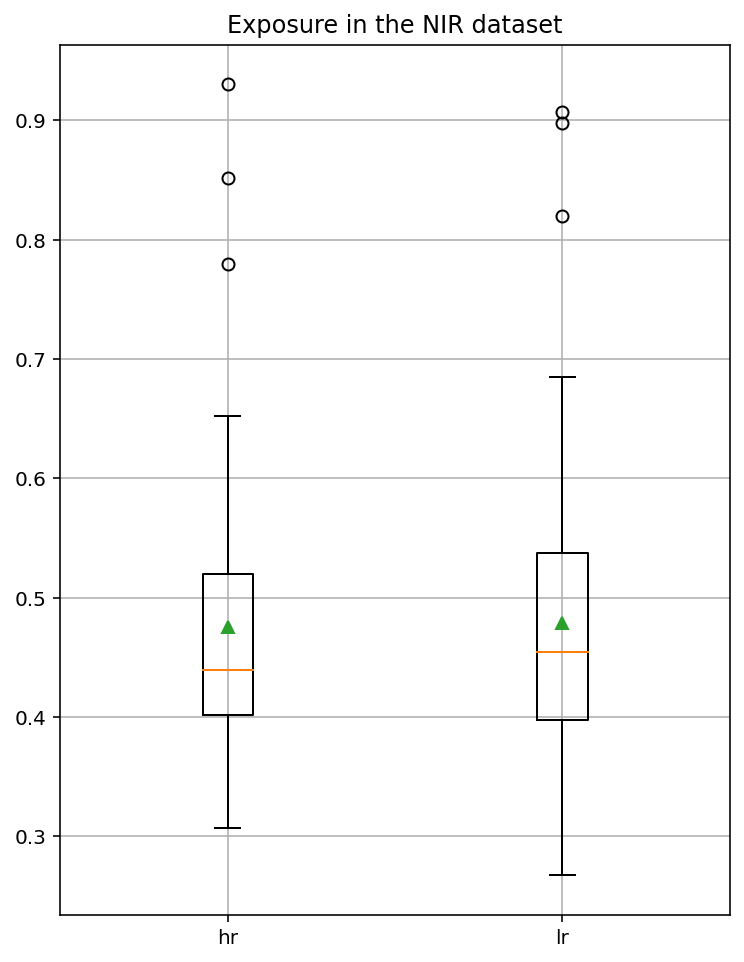

In [5]:
def demo_xy_exposure_boxplot(dataset_path, title):
    _, _, x, y = make_data(dataset_path)
    sets = [x, y]
    sets_labels = ['hr', 'lr']
    box_data = []
    for img_set in sets:
        box_data.append([img.mean() for img in img_set])

    plt.figure(figsize=(6, 8))
    plt.boxplot(box_data, labels=sets_labels, showmeans=True)
    plt.title(title)
    plt.grid(True)
    plt.show()
    
demo_xy_exposure_boxplot('data/dat-red-one-per-scene.npy', 'Exposure in the RED dataset')
demo_xy_exposure_boxplot('data/dat-nir-one-per-scene.npy', 'Exposure in the NIR dataset')

This issue was mitigated by equalizing histogram on whole dataset before training. The network trained this way can be used on real (not equalized) images and produce more visually pleasing results. Because of the dataset modification it is pointless to compare loss after such modification. However, the increase in quality is visible in later section, when results are compared to standard resizing algorithms.

The issues of clouds appearing on photos and some shifts between x and y seem to be resolved statistically in the training.

## Comparison
The goal of the analysis is to compare results of predictions with different resampling algorithms. Metrics of PSNR and MSE were chosen for this task (notice that MSE was also the metric used for loss computation during training). The results are presented on heatmap in form of _all vs all_ (the heatmaps show every possible comparison, so some parts of them are not much needed, hovewer this is rather convinient way of comparing all results.)

The charts were made using data from `test` subsets. The `real` row denotes _y_ (_LR_) data, that means real photos. The `preds` are predictions based on `test` subsets. The `pred_real` was trained on normal data, `pred_eqhist` was trained on data with equalized histograms (but notice it was tested and compared using **non-equalized** images). The rest of rows and columns designate _LR_ images created by resizng _HR_ images with different algorithms.

All of mentioned methods to create _LR_ images are compared in the heatmaps.

### NIR

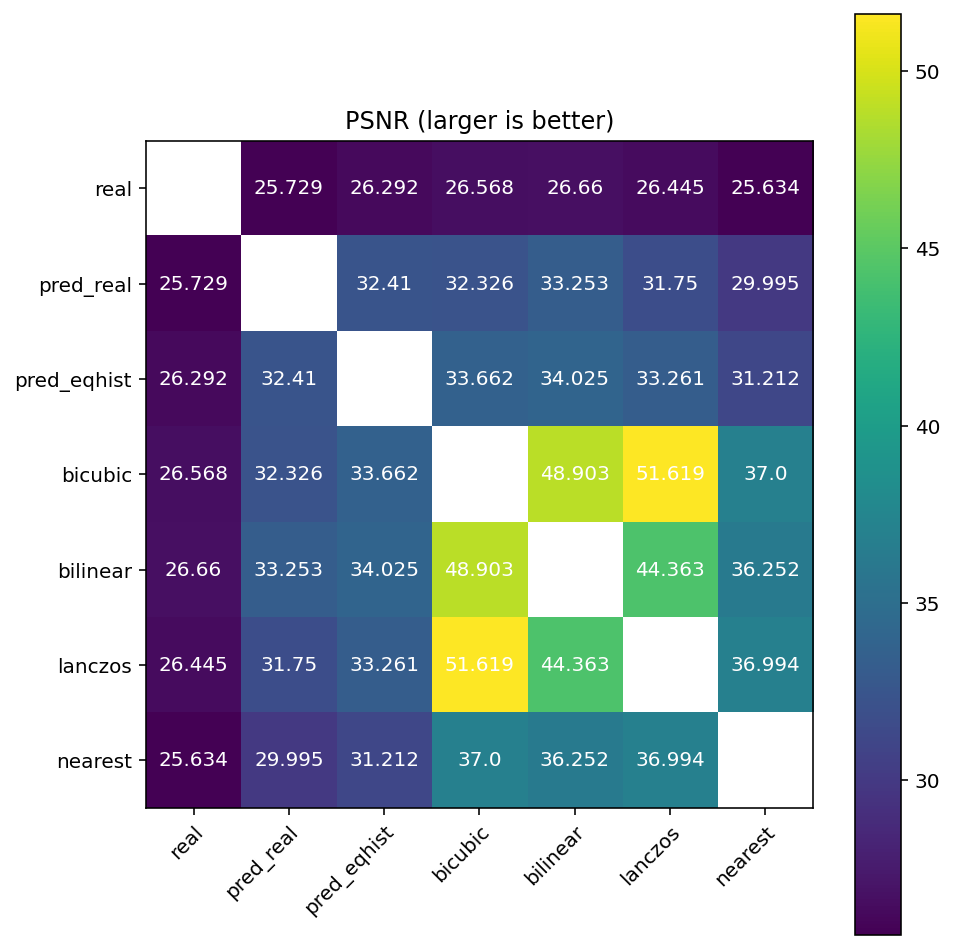

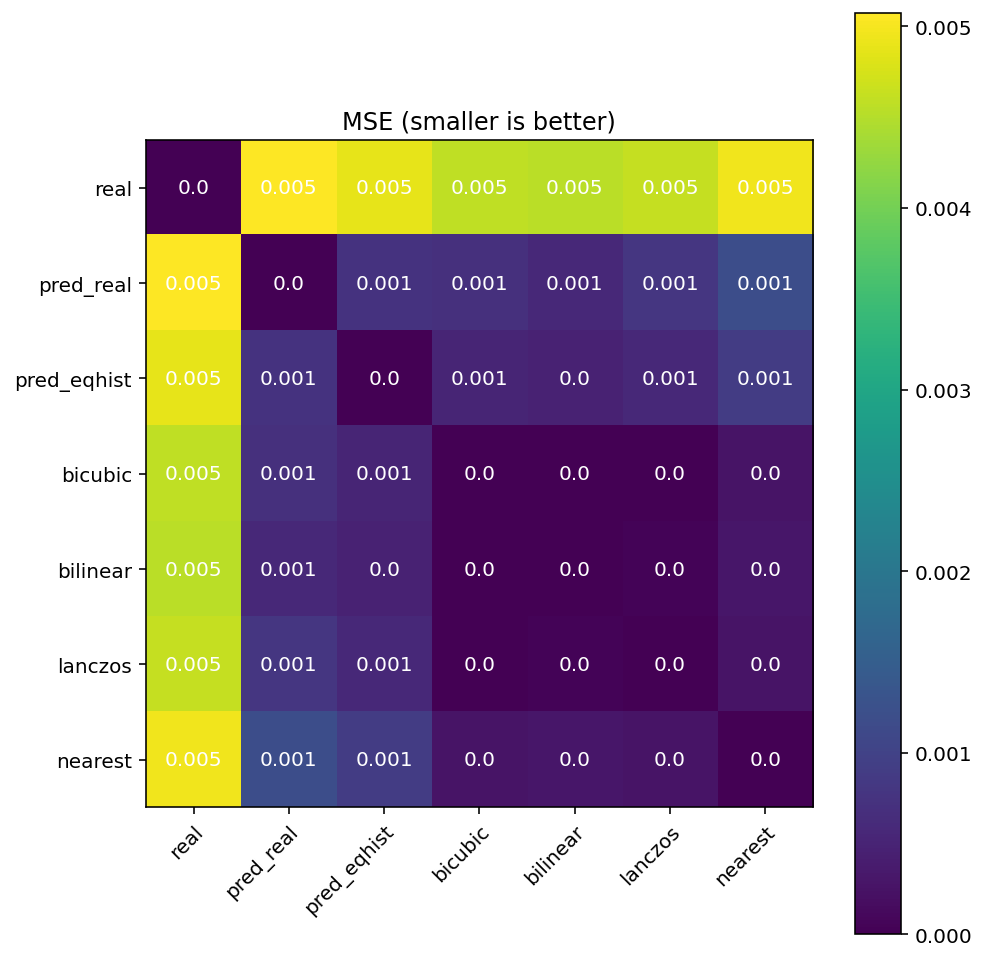

In [9]:
demo_heatmap('data/dat-nir-one-per-scene.npy',
             ('log/model-20-07-22-10:54:06-nir-real.h5',
              'log/model-20-07-21-19:19:49-nir-eqhist.h5'))

### RED

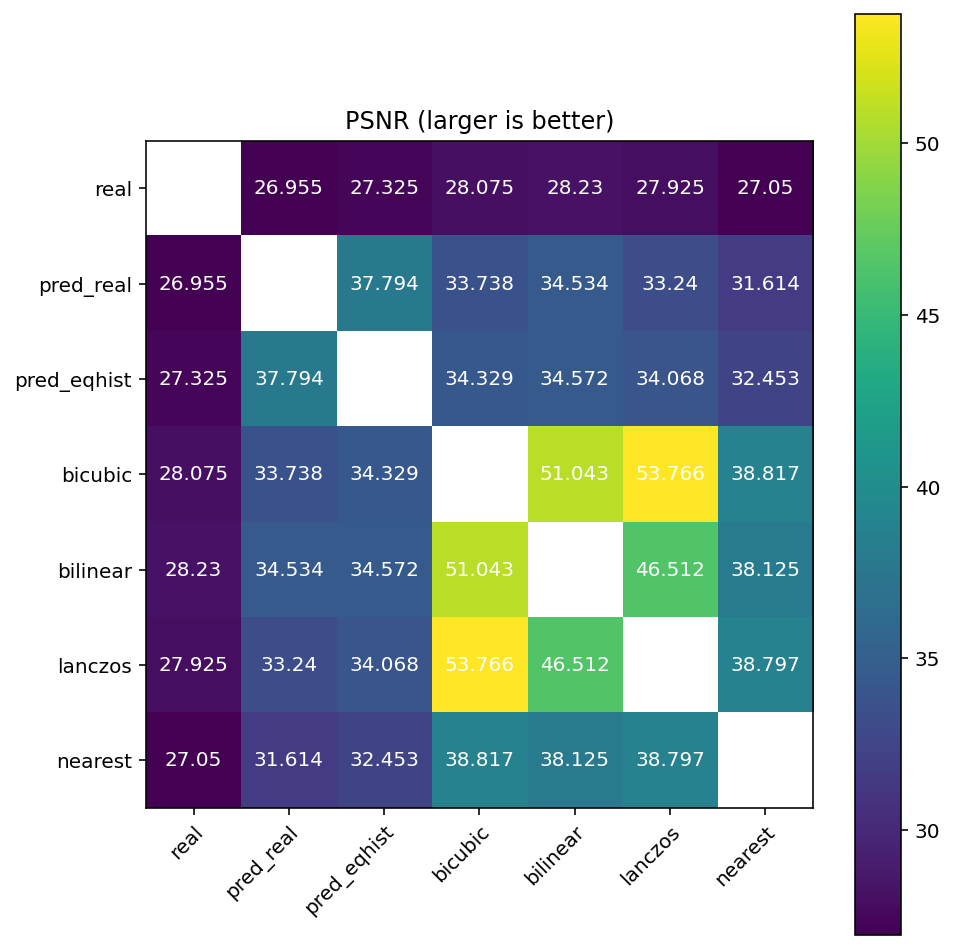

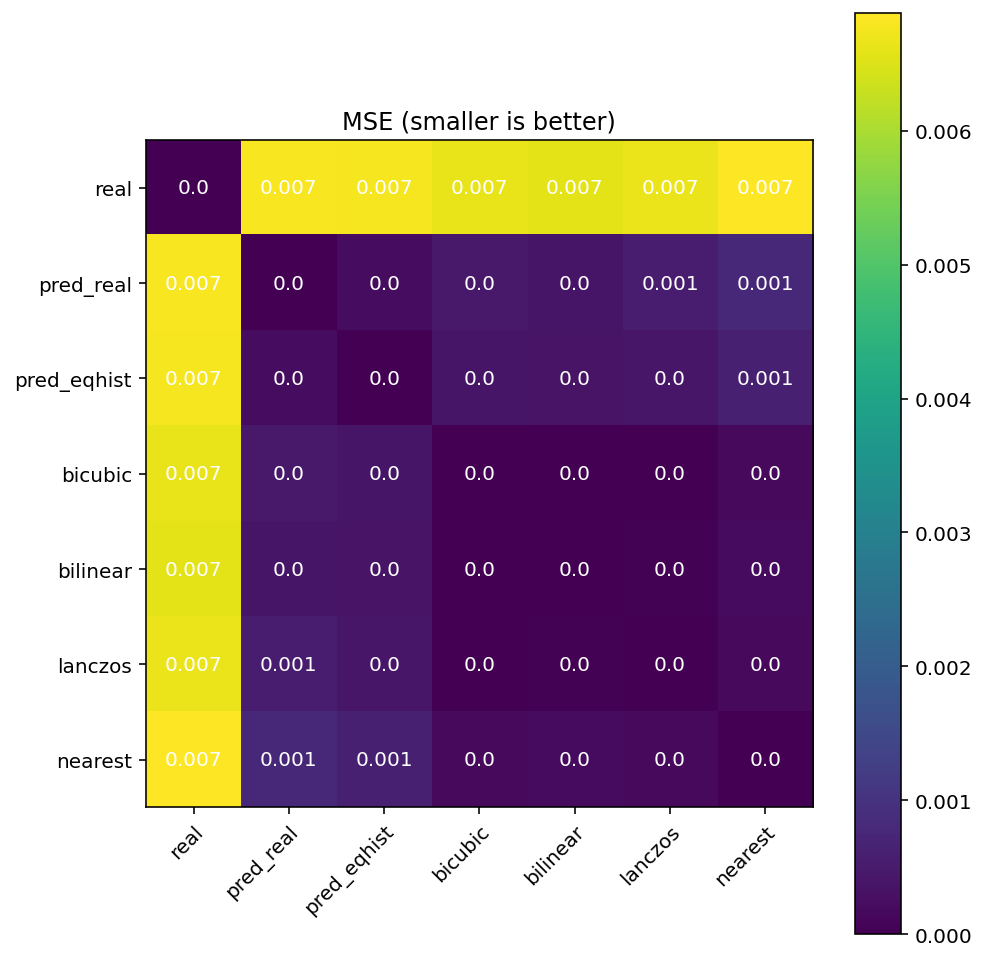

In [7]:
demo_heatmap('data/dat-red-one-per-scene.npy',
             ('log/model-20-07-21-18:28:38-red-real.h5',
              'log/model-20-07-21-20:14:09-red-eqhist.h5'))

## Summary

As seen in the charts equalization of histogram during training improved the results. _LR_ images created with such network are more similar to real photos and images created with resizing algorithms. The predictions of the network seem to be most similar to the bilinear algorithm.

The visual result of the network is presented below. This also shows the mentioned issue with differing exposure between real _LR_ and _HR_ images.

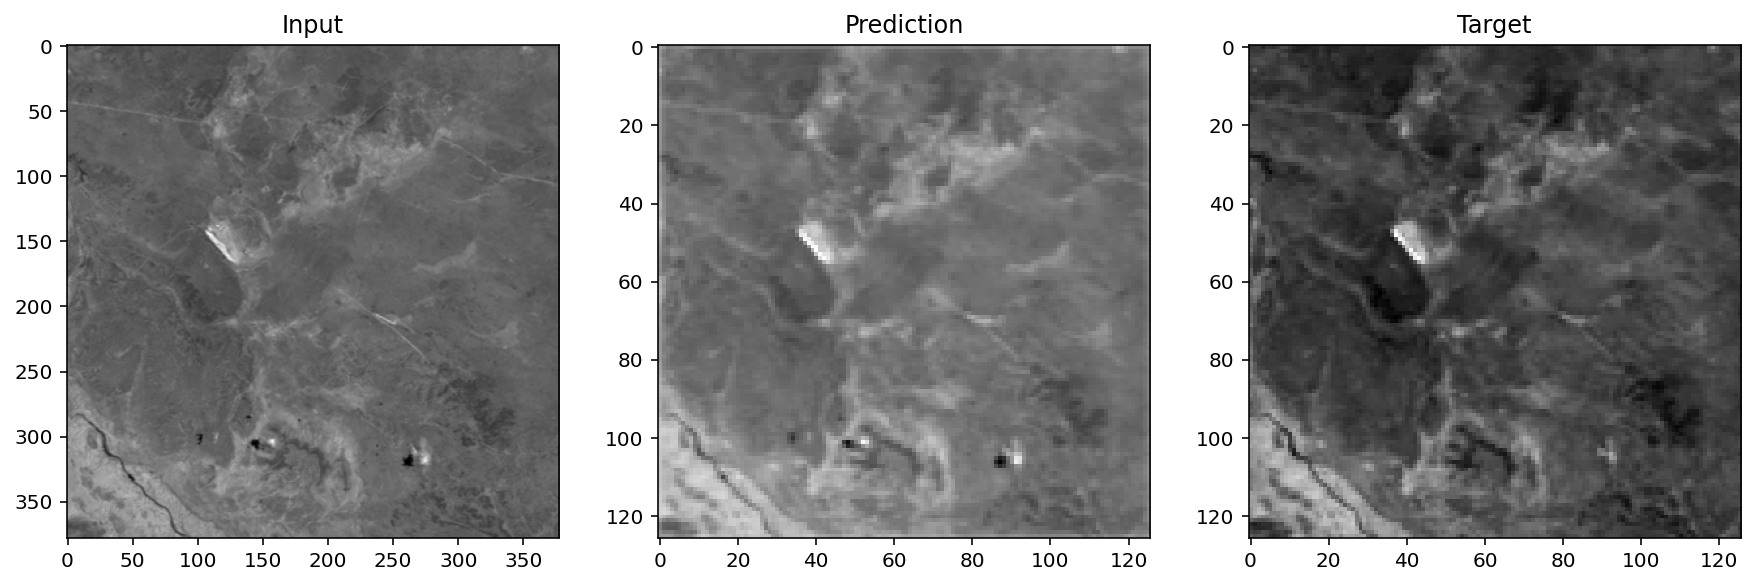

In [8]:
model = make_model()
model.load_weights('log/model-20-07-21-20:14:09-red-eqhist.h5')

x_train, y_train, x_test, y_test = make_data('data/dat-red-one-per-scene.npy')

p = model.predict(x_test[[5]])

plt.figure(figsize=((15, 5)))

plt.subplot(1, 3, 1)
plt.imshow(x_test[[5]].reshape(378, 378), cmap="gray")
plt.title("Input")

plt.subplot(1, 3, 2)
plt.imshow(p.reshape(126, 126), cmap="gray")
plt.title("Prediction")

plt.subplot(1, 3, 3)
plt.imshow(y_test[[5]].reshape(126, 126), cmap="gray", norm=None)
plt.title("Target")

plt.show()